# Neural posterior estimation

This tutorial demonstrates how to perform neural posterior estimation (NPE) with `lampe`.

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from itertools import islice
from tqdm import tqdm

from lampe.data import JointLoader
from lampe.distributions import BoxUniform
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner
from lampe.utils import GDStep

## Simulator

In [2]:
LABELS = [r'$\theta_1$', r'$\theta_2$', r'$\theta_3$']
LOWER = -torch.ones(3)
UPPER = torch.ones(3)

prior = BoxUniform(LOWER, UPPER)

def simulator(theta: torch.Tensor) -> torch.Tensor:
    x = torch.stack([
        theta[..., 0] + theta[..., 1] * theta[..., 2],
        theta[..., 0] * theta[..., 1] + theta[..., 2],
    ], dim=-1)

    return x + 0.05 * torch.randn_like(x)

theta = prior.sample()
x = simulator(theta)

print(theta, x, sep='\n')

tensor([ 0.4543,  0.4701, -0.6797])
tensor([ 0.0923, -0.4156])


In [3]:
loader = JointLoader(prior, simulator, batch_size=1024, vectorized=True)

## Training

Similar to PyTorch, `lampe` provides building blocks that have to be assembled by the user to perform inference. In the case of neural posterior estimation (NPE), we train a conditional normalizing flow $p_\phi(\theta | x)$ to approximate the posterior distribution $p(\theta | x)$. The [`lampe.inference`](https://francois-rozet.github.io/lampe/api/inference.html) module provides the [`NPE`](https://francois-rozet.github.io/lampe/api/inference.html#lampe.inference.NPE) class to create a normalizing flow adapted to the simulator's input and output sizes. By default, the normalizing flow is a masked autoregressive flow (MAF) with affine transforms.

In [4]:
estimator = NPE(3, 2, transforms=3, hidden_features=[64] * 3)
estimator

NPE(
  (flow): MAF(
    (transforms): ModuleList(
      (0): MaskedAutoregressiveTransform(
        (base): MonotonicAffineTransform()
        (order): [0, 1, 2]
        (params): MaskedMLP(
          (0): MaskedLinear(in_features=5, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): MaskedLinear(in_features=64, out_features=6, bias=True)
        )
      )
      (1): MaskedAutoregressiveTransform(
        (base): MonotonicAffineTransform()
        (order): [2, 1, 0]
        (params): MaskedMLP(
          (0): MaskedLinear(in_features=5, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=64, bias=True)
          (5): ReLU()
          (6): Ma

In the case of NPE, the loss to minimize is the expected log-likelihood of the data $ \mathbb{E}_{p(\theta, x)} \big[ -\log p_\phi(\theta | x) \big] $, which is easy to implement ourselves.

In [5]:
def loss(theta, x):
    log_p = estimator(theta, x)  # log p(theta | x)
    return -log_p.mean()

For other algorithms, it might not be as straightforward to implement the loss. Conveniently, the [`lampe.inference`](https://francois-rozet.github.io/lampe/api/inference.html) module provides the losses of the algorithms it implements, in this case [`NPELoss`](https://francois-rozet.github.io/lampe/api/inference.html#lampe.inference.NPELoss).

In [6]:
loss = NPELoss(estimator)

We implement the training routine as a series of stochastic gradient descent (SGD) epochs over the training set. Because `lampe` is based on PyTorch, any `torch` optimizer can be used (e.g. [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam), ...) and features such as gradient clipping can be easily implemented.

In [7]:
optimizer = optim.AdamW(estimator.parameters(), lr=1e-3)
step = GDStep(optimizer, clip=1.)  # gradient descent step with gradient clipping

estimator.train()

with tqdm(range(64), unit='epoch') as tq:
    for epoch in tq:
        losses = torch.stack([
            step(loss(theta, x))
            for theta, x in islice(loader, 256)  # 256 batches per epoch
        ])

        tq.set_postfix(loss=losses.mean().item())

100%|██████████| 64/64 [05:13<00:00,  4.90s/epoch, loss=-2.5] 


## Inference

Now that the posterior estimator is trained, we can use it to perform inference. For instance, we can inspect the posterior of any observation $x^*$. Since normalizing flows are proper distributions, we can sample directly from $p_\phi(\theta | x^*)$ and visualize the distribution with the [`corner`](https://francois-rozet.github.io/lampe/api/plots.html#lampe.plots.corner) function provided by the [`lampe.plots`](https://francois-rozet.github.io/lampe/api/plots.html) module. 

In [8]:
theta_star = prior.sample()
x_star = simulator(theta_star)

estimator.eval()

with torch.no_grad():
    samples = estimator.sample(x_star, (2**16,))

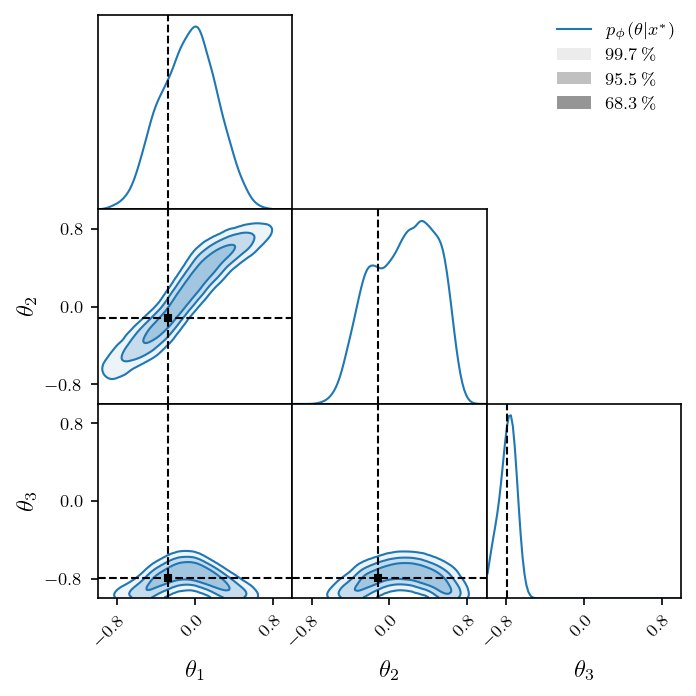

In [9]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2,
    bounds=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    markers=[theta_star],
    figsize=(4.8, 4.8),
)